In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

2024-02-28 19:07:00.683108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 19:07:00.711160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 19:07:00.711194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 19:07:00.711825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 19:07:00.717294: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=8
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"
train_gen = DataGenerator(train_path,
                          mode="unsupervised_with_h4pt",
                          rho=32,
                          crop_size=128)
val_gen = DataGenerator(val_path,
                          mode="unsupervised_with_h4pt",
                          rho=32,
                          crop_size=128)


# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature=(  #input
                    (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    ),
                     # output
                    (tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32), 
                     tf.TensorSpec(shape=(8,),dtype=tf.float32))
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

sample_input, sample_output = next(iter(train_ds))
print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
for i in sample_output:
    print(i.shape)

2024-02-28 19:07:04.493487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 19:07:04.527491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 19:07:04.534265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

reshuffling dataset
input shapes:
(8, 128, 128, 3)
(8, 128, 128, 3)
(8, 240, 320, 3)
(8, 2)
output shape
(8, 240, 320, 3)
(8, 8)


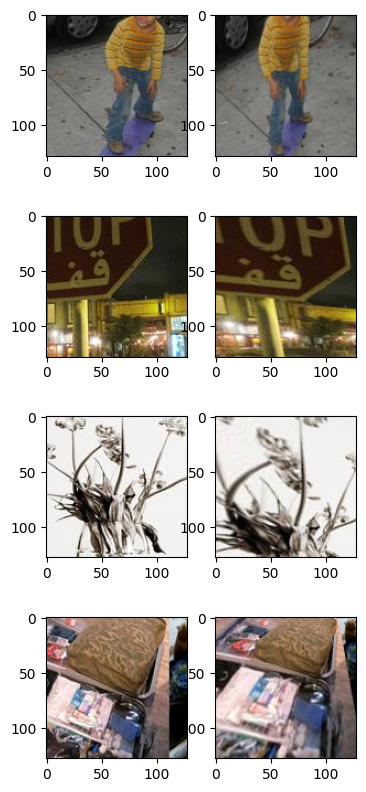

In [4]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [5]:
# build new model with TensorDLT and STN added
homography_net = model_v2()
homography_net.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho32')

# retrieve the input of the network
cropped_img1 = keras.layers.Input(shape=im_crop_shape)
cropped_img2 = keras.layers.Input(shape=im_crop_shape)
img_ori = keras.layers.Input(shape=im_ori_shape)

h4pt_batch = homography_net([cropped_img1,cropped_img2]) # batch by 8

upper_left_corner = keras.layers.Input(shape=(2,)) # batch by 2

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=h4pt_batch,
                       upper_left_corner=upper_left_corner,
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(img_ori,
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

full_model = keras.Model(inputs=[cropped_img1,
                                 cropped_img2,
                                 img_ori,
                                 upper_left_corner,
                                 ], 
                        outputs=[img_pred,h4pt_batch])

# rename output layers
full_model.layers[2]._name = 'h4pt_output'
full_model.layers[-1]._name = 'img_output'

full_model.summary()


2024-02-28 19:07:11.273114: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-28 19:07:11.634384: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x90b0dc0


KerasTensor(type_spec=TensorSpec(shape=(8, 3, 3), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 h4pt_output (Functional)    (None, 8)                    3777980   ['input_4[0][0]',             
                                                          0          'input_5[0][0]']             
                                               

2024-02-28 19:07:14.784068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 19:07:14.862186: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[  9. -12.   9.  23.  -6. -23. -21. -21.]
 [-11. -12. -13.   4. -10.  30.  28.  25.]
 [-10. -28.  31. -14.  22.   8.  26.  18.]
 [  5.  26.  15. -10.  -8.  22.   0. -10.]
 [ 17.  21.   6.  25.  21.   9.  12.  -5.]
 [ -4.  -5. -10.  -3.   5. -10. -26. -12.]
 [ 21.  11.  -1.  -3.  21.   0.  -6. -32.]
 [-31.   6.  -4.   6.   4. -31. -29. -24.]], shape=(8, 8), dtype=float32)
tf.Tensor(
[[ 13.  -9.   6.  20.  -3. -21. -20. -17.]
 [ -9. -11. -22.   7. -11.  27.  22.  31.]
 [-12. -29.  31. -21.  16.   3.  24.  21.]
 [  9.  25.  17. -10.  -5.  25.   0. -12.]
 [  9.  16.   5.  22.  20.   7.  12.  -7.]
 [ -3.  -5. -13.   0.   3. -12. -24. -12.]
 [ 15.   6.   0.  -5.  18.  -4.  -6. -31.]
 [-28.  10.  -6.   5.   9. -24. -29. -23.]], shape=(8, 8), dtype=float32)


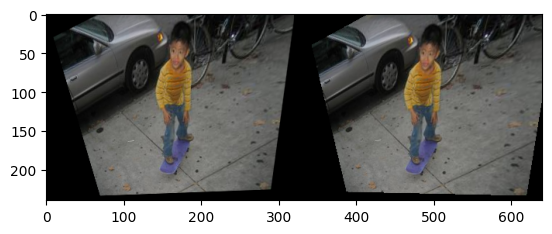

In [6]:
import numpy as np
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
assert(sample_model_output[0].shape==sample_input[2].shape)
print(sample_output[-1])
print(tf.round(sample_model_output[1]))

import matplotlib.pyplot as plt
plt.imshow(np.hstack( ((sample_output[0][0,:,:,:]).numpy(),
                      (sample_model_output[0][0,:,:,:]).numpy())
            )
           )


In [7]:
# define loss and metrics
def loss_img(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred)) # notice 1-norm is used


def metric_abs(y_true, y_pred):
    """computes the mean difference between predicted and actual corner shift
    values in x and y direction

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

# compile model
full_model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-5,
                                                    clipvalue=0.5),
                    loss=loss_img,
                    loss_weights = [1.0,0.0], # use only image loss
                    metrics=[[loss_img,],
                            [metric_abs,metric_dist]])

In [8]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))
# start training
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = './checkpoint_mdl_unsupervised'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_freq = steps_per_epoch*10
    )

history = full_model.fit(train_ds,
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_ds,
                         validation_steps=int(np.floor(1000/batch_size)),
                         validation_freq=1,
                         verbose=True,
                         callbacks=[reduce_lr, checkpoint_callback])

Epoch 1/100


2024-02-28 19:07:32.397843: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f95219ea070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 19:07:32.397876: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-28 19:07:32.401408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709165252.454696   74976 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
import numpy as np
ind = np.array([0,1,2,3])
a = np.random.randn(4,2)
a

array([[-2.0245613 ,  0.0795189 ],
       [ 1.59863843,  1.00238566],
       [-0.32244695, -1.69606482],
       [-0.68382129,  0.39075812]])

In [21]:
a[(ind+1)%4,:]

array([[ 1.59863843,  1.00238566],
       [-0.32244695, -1.69606482],
       [-0.68382129,  0.39075812],
       [-2.0245613 ,  0.0795189 ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


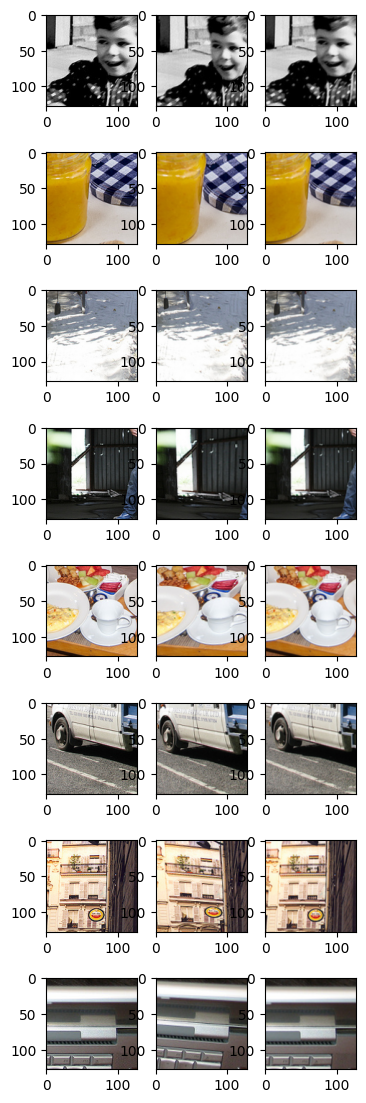

In [71]:
# see how the model is doing
sample_model_output = full_model(sample_input)
plt.figure(figsize=(4,14))
for i in range(8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+3)
    plt.imshow(tf.squeeze(sample_model_output[i,:,:,:])/255.)
plt.show()